In [3]:
import sys
sys.path.append('../notebooks')

import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

In [4]:
_d = np.load('../../data_128_train.npz')
X = _d['X']
Y = _d['Y']

In [5]:
print X.shape
print Y.shape

(5635, 128, 128)
(5635, 128, 128)


In [6]:
nsamples = X.shape[0]

train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
#train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.25)
X_train = X[train_indices][:,None,:,:]
Y_train = Y[train_indices][:,None,:,:]
X_test = X[test_indices][:,None,:,:]
Y_test = Y[test_indices][:,None,:,:]

In [7]:
print X_train.shape
print Y_train.shape
print X_train.min(), X_train.max()

print X_test.shape

(5071, 1, 128, 128)
(5071, 1, 128, 128)
0.0 1.0
(564, 1, 128, 128)


/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


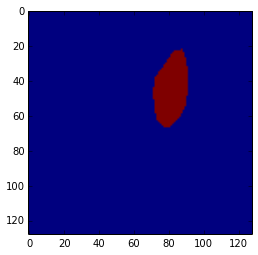

In [8]:
#pl.imshow(X_train[0].squeeze())
pl.imshow(Y_train[0].squeeze())

In [9]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 128, 128)


In [10]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float16'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, GaussianNoise, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, PReLU
import keras.backend as K
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [11]:
import theano
print theano.config.device

gpu0


In [17]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [18]:
input_img = Input(shape=input_shape)
x = Convolution2D(16, 7, 7, border_mode='same')(input_img)
x = LeakyReLU()(x)
#x = Convolution2D(16, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool1 = x = Dropout(0.25, name='pool1')(x)

x = Convolution2D(16, 5, 5, border_mode='same')(x)
x = LeakyReLU()(x)
#x = Convolution2D(32, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool2 = x = Dropout(0.25, name='pool2')(x)

x = Convolution2D(16, 5, 5, border_mode='same')(x)
x = LeakyReLU()(x)
#x = Convolution2D(64, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool3 = x = Dropout(0.25, name='pool3')(x)

# -- location map
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='sum')
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='sum')
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

model = Model(
    input=input_img,
    output=outmap
)

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')

#loss=dice_coef_loss, metrics=[dice_coef]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_5 (InputLayer)               (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D)   (None, 16, 128, 128)800         input_5[0][0]                    
____________________________________________________________________________________________________
leakyrelu_29 (LeakyReLU)           (None, 16, 128, 128)0           convolution2d_27[0][0]           
____________________________________________________________________________________________________
maxpooling2d_15 (MaxPooling2D)     (None, 16, 64, 64)  0           leakyrelu_29[0][0]               
___________________________________________________________________________________________

Train on 5071 samples, validate on 564 samples
Epoch 1/10
5071/5071 [==============================] - 19s - loss: 0.0226 - dice_coef: 0.4740 - val_loss: 0.0227 - val_dice_coef: 0.4373
Epoch 2/10
5071/5071 [==============================] - 19s - loss: 0.0224 - dice_coef: 0.4804 - val_loss: 0.0232 - val_dice_coef: 0.4551
Epoch 3/10
5071/5071 [==============================] - 18s - loss: 0.0224 - dice_coef: 0.4801 - val_loss: 0.0222 - val_dice_coef: 0.4705
Epoch 4/10
5071/5071 [==============================] - 18s - loss: 0.0224 - dice_coef: 0.4789 - val_loss: 0.0225 - val_dice_coef: 0.4991
Epoch 5/10
5071/5071 [==============================] - 18s - loss: 0.0224 - dice_coef: 0.4798 - val_loss: 0.0226 - val_dice_coef: 0.4602
Epoch 6/10
5071/5071 [==============================] - 18s - loss: 0.0223 - dice_coef: 0.4798 - val_loss: 0.0219 - val_dice_coef: 0.4777
Epoch 7/10
5071/5071 [==============================] - 18s - loss: 0.0223 - dice_coef: 0.4807 - val_loss: 0.0222 - val_dice_

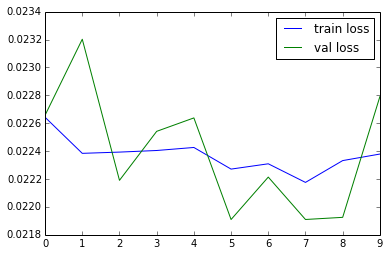

In [27]:
if True:
    history = model.fit(
        X_train, Y_train,
        batch_size=32,
        validation_data=(X_test, Y_test),
        nb_epoch=10
    )
    
    pl.plot(history.history['loss'], label='train loss')
    pl.plot(history.history['val_loss'], c='g', label='val loss')
    pl.legend()

In [28]:
if False:
    model_dir = '.'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights.h5'))

In [29]:
import skimage.measure as measure

def predict(X):
    Y_pred = model.predict(X)
    Y_pred_proba = Y_pred
    Y_pred = Y_pred > 0.3
    for i in range(Y_pred.shape[0]):
        # Clear prediction where we detect to little pixels
        # Figure it out by
        # pl.hist(np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1))
        if np.sum(Y_pred[i]) < 0:
            Y_pred[i,:] = 0
    return Y_pred, Y_pred_proba

Y_pred, Y_pred_proba = predict(X_test)
print "test set score : ", utils.dice_coefficient(Y_pred, Y_test)

test set score :  0.594832615118


In [ ]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_pred[i], Y_test[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

In [ ]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

In [ ]:
#i = 50
#i = 47

#for i in lowest[-15:-10]:
#for i in lowest[215:220]:
for i in lowest[10:15]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_pred[i], Y_test[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X_test[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y_test[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    
    #blob_proba = np.mean(Y_pred_proba[i][Y_pred[i] == 1])
    #pl.title('prediction proba %f' % Y_pred_binary[i])
    pl.imshow(Y_pred_proba[i].squeeze(), vmin=0, vmax=1)